In [8]:
from typing import Iterable, Mapping
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
from core.viz import plot_line, create_subplot_grid, plot_bar, plot_statistical_strip
from core.s3 import S3AssetManager

In [9]:
notebook_name = "okuo_hacienda_humedades_feder"
s3 = S3AssetManager(notebook_name=notebook_name)

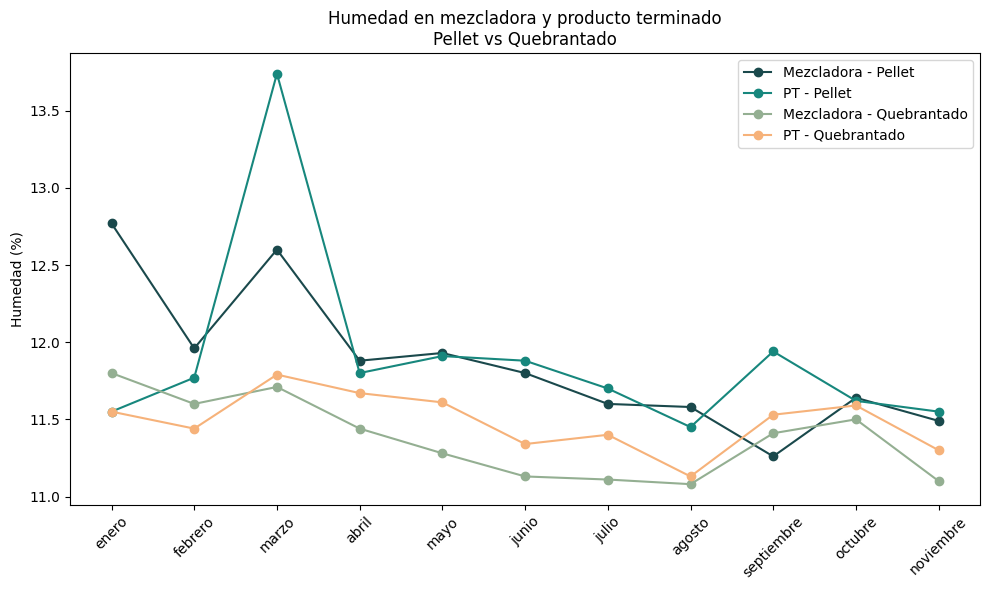

('humedades_pellet_quebrantado.xlsx',
 'humedades_pellet_quebrantado.png',
        mes  humedad_mezcladora  humedad_pt  diff_mezcladora_pt        etapa
 0    enero               12.77       11.55               -1.22       pellet
 1    enero               11.80       11.55               -0.25  quebrantado
 2  febrero               11.96       11.77               -0.19       pellet
 3  febrero               11.60       11.44               -0.16  quebrantado
 4    marzo               12.60       13.74                1.14       pellet)

In [10]:

data_pellet = [
    ("enero", 12.77, 11.55),
    ("febrero", 11.96, 11.77),
    ("marzo", 12.60, 13.74),
    ("abril", 11.88, 11.80),
    ("mayo", 11.93, 11.91),
    ("junio", 11.80, 11.88),
    ("julio", 11.60, 11.70),
    ("agosto", 11.58, 11.45),
    ("septiembre", 11.26, 11.94),
    ("octubre", 11.64, 11.62),
    ("noviembre", 11.49, 11.55),
]

df_pellet = pd.DataFrame(data_pellet, columns=["mes", "humedad_mezcladora", "humedad_pt"])
df_pellet["mes"] = df_pellet["mes"].str.lower()
df_pellet["diff_mezcladora_pt"] = (df_pellet["humedad_pt"] - df_pellet["humedad_mezcladora"]).round(2)
df_pellet["etapa"] = "pellet"


data_queb = [
    ("sep", 11.41, 11.53),
    ("octubre", 11.50, 11.59),
    ("marzo", 11.71, 11.79),
    ("junio", 11.13, 11.34),
    ("julio", 11.11, 11.40),
    ("agosto", 11.08, 11.13),
    ("abril", 11.44, 11.67),
    ("noviembre", 11.10, 11.30),
    ("febrero", 11.60, 11.44),
    ("enero", 11.80, 11.55),
    ("mayo", 11.28, 11.61),
]

df_queb = pd.DataFrame(data_queb, columns=["mes", "humedad_mezcladora", "humedad_pt"])

# Normalizar nombres de meses
mapping = {
    "enero": "enero",
    "febrero": "febrero",
    "marzo": "marzo",
    "abril": "abril",
    "mayo": "mayo",
    "junio": "junio",
    "julio": "julio",
    "agosto": "agosto",
    "sep": "septiembre",
    "septiembre": "septiembre",
    "octubre": "octubre",
    "noviembre": "noviembre",
}
df_queb["mes"] = df_queb["mes"].str.lower().map(mapping)

df_queb["diff_mezcladora_pt"] = (df_queb["humedad_pt"] - df_queb["humedad_mezcladora"]).round(2)
df_queb["etapa"] = "quebrantado"

# ---------- Unir ambas tablas ----------
orden_meses = [
    "enero",
    "febrero",
    "marzo",
    "abril",
    "mayo",
    "junio",
    "julio",
    "agosto",
    "septiembre",
    "octubre",
    "noviembre",
    "diciembre",
]

df_pellet["mes"] = pd.Categorical(df_pellet["mes"], ordered=True, categories=orden_meses)
df_queb["mes"] = pd.Categorical(df_queb["mes"], ordered=True, categories=orden_meses)

df_all = pd.concat([df_pellet, df_queb], ignore_index=True)
df_all = df_all.sort_values(["mes", "etapa"]).reset_index(drop=True).round(2)

# Guardar CSV
csv_path = "humedades_pellet_quebrantado.xlsx"
df_all.to_csv(csv_path, index=False)
df_all.to_excel(csv_path, index=False)

# ---------- Gráfica con colores corporativos ----------
CORPORATE_COLORS = [
    "#1A494C",
    "#17877D",
    "#94AF92",
    "#F6B27A",
    "#F18F01",
    "#E4572E",
    "#6C757D",
    "#343A40",
    "#A3CED0",
]

plt.figure(figsize=(10, 6))

# Para asegurar orden de meses en el eje X
mes_order = [m for m in orden_meses if m in df_all["mes"].cat.categories]
mes_labels = [m.capitalize() for m in mes_order if m in df_all["mes"].unique().categories]

# Filtrar y ordenar por mes para cada etapa
df_pellet_plot = df_all[df_all["etapa"] == "pellet"].sort_values("mes")
df_queb_plot = df_all[df_all["etapa"] == "quebrantado"].sort_values("mes")

# Se crean 4 líneas: mezcladora/PT para pellet/quebrantado
plt.plot(
    df_pellet_plot["mes"].astype(str),
    df_pellet_plot["humedad_mezcladora"],
    marker="o",
    label="Mezcladora - Pellet",
    color=CORPORATE_COLORS[0],
)
plt.plot(
    df_pellet_plot["mes"].astype(str),
    df_pellet_plot["humedad_pt"],
    marker="o",
    label="PT - Pellet",
    color=CORPORATE_COLORS[1],
)
plt.plot(
    df_queb_plot["mes"].astype(str),
    df_queb_plot["humedad_mezcladora"],
    marker="o",
    label="Mezcladora - Quebrantado",
    color=CORPORATE_COLORS[2],
)
plt.plot(
    df_queb_plot["mes"].astype(str),
    df_queb_plot["humedad_pt"],
    marker="o",
    label="PT - Quebrantado",
    color=CORPORATE_COLORS[3],
)

plt.xticks(rotation=45)
plt.ylabel("Humedad (%)")
plt.title("Humedad en mezcladora y producto terminado\nPellet vs Quebrantado")
plt.legend()
plt.tight_layout()

img_path = "humedades_pellet_quebrantado.png"
plt.savefig(img_path)
plt.show()

(csv_path, img_path, df_all.head())


In [15]:
df_pl = df_all[df_all["etapa"] == "pellet"]
rename = {"mes": "Mes",
          "humedad_mezcladora": "Humedad Mezcladora",
           "humedad_pt": "Humedad PT",
          "diff_mezcladora_pt": "Δ (PT-Mezcladora)",}
df_pl.rename(columns=rename, inplace=True)
df_pl_dep = df_pl[rename.values()]
df_pl_dep


/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_60598/1340857687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pl.rename(columns=rename, inplace=True)


,Mes,Humedad Mezcladora,Humedad PT,Δ (PT-Mezcladora)
0,enero,12.77,11.55,-1.22
2,febrero,11.96,11.77,-0.19
4,marzo,12.60,13.74,1.14
6,abril,11.88,11.80,-0.08
8,mayo,11.93,11.91,-0.02
10,junio,11.80,11.88,0.08
12,julio,11.60,11.70,0.10
14,agosto,11.58,11.45,-0.13
16,septiembre,11.26,11.94,0.68
18,octubre,11.64,11.62,-0.02


In [16]:
df_other = df_all[df_all["etapa"] != "pellet"]
df_other.rename(columns=rename, inplace=True)
df_other_dep = df_other[rename.values()]
df_other_dep

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_60598/3591105456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_other.rename(columns=rename, inplace=True)


,Mes,Humedad Mezcladora,Humedad PT,Δ (PT-Mezcladora)
1,enero,11.80,11.55,-0.25
3,febrero,11.60,11.44,-0.16
5,marzo,11.71,11.79,0.08
7,abril,11.44,11.67,0.23
9,mayo,11.28,11.61,0.33
11,junio,11.13,11.34,0.21
13,julio,11.11,11.40,0.29
15,agosto,11.08,11.13,0.05
17,septiembre,11.41,11.53,0.12
19,octubre,11.50,11.59,0.09


In [ ]:

data_pellet = [
    ("enero", 12.77, 11.55),
    ("febrero", 11.96, 11.77),
    ("marzo", 12.60, 13.74),
    ("abril", 11.88, 11.80),
    ("mayo", 11.93, 11.91),
    ("junio", 11.80, 11.88),
    ("julio", 11.60, 11.70),
    ("agosto", 11.58, 11.45),
    ("septiembre", 11.26, 11.94),
    ("octubre", 11.64, 11.62),
    ("noviembre", 11.49, 11.55),
]

df_pellet = pd.DataFrame(
    data_pellet,
    columns=["mes", "humedad_mezcladora", "humedad_pt"]
)
df_pellet["mes"] = df_pellet["mes"].str.lower()
df_pellet["diff_mezcladora_pt"] = (
    df_pellet["humedad_pt"] - df_pellet["humedad_mezcladora"]
).round(2)
df_pellet["etapa"] = "pellet"

# ---------- Datos de humedades en QUEBRANTADO ----------
data_queb = [
    ("sep", 11.41, 11.53),
    ("octubre", 11.50, 11.59),
    ("marzo", 11.71, 11.79),
    ("junio", 11.13, 11.34),
    ("julio", 11.11, 11.40),
    ("agosto", 11.08, 11.13),
    ("abril", 11.44, 11.67),
    ("noviembre", 11.10, 11.30),
    ("febrero", 11.60, 11.44),
    ("enero", 11.80, 11.55),
    ("mayo", 11.28, 11.61),
]

df_queb = pd.DataFrame(
    data_queb,
    columns=["mes", "humedad_mezcladora", "humedad_pt"]
)

# Normalizar nombres de meses
mapping = {
    "enero": "enero",
    "febrero": "febrero",
    "marzo": "marzo",
    "abril": "abril",
    "mayo": "mayo",
    "junio": "junio",
    "julio": "julio",
    "agosto": "agosto",
    "sep": "septiembre",
    "septiembre": "septiembre",
    "octubre": "octubre",
    "noviembre": "noviembre",
}

df_queb["mes"] = df_queb["mes"].str.lower().map(mapping)
df_queb["diff_mezcladora_pt"] = (
    df_queb["humedad_pt"] - df_queb["humedad_mezcladora"]
).round(2)
df_queb["etapa"] = "quebrantado"

# ---------- Unir ambas tablas ----------
orden_meses = [
    "enero",
    "febrero",
    "marzo",
    "abril",
    "mayo",
    "junio",
    "julio",
    "agosto",
    "septiembre",
    "octubre",
    "noviembre",
    "diciembre",
]

df_pellet["mes"] = pd.Categorical(
    df_pellet["mes"], ordered=True, categories=orden_meses
)
df_queb["mes"] = pd.Categorical(
    df_queb["mes"], ordered=True, categories=orden_meses
)

df_all = pd.concat([df_pellet, df_queb], ignore_index=True)
df_all = df_all.sort_values(["mes", "etapa"]).reset_index(drop=True).round(2)

# (Opcional) guardar datos
#df_all.to_csv("humedades_pellet_quebrantado.csv", index=False)
s3.save_dataframe(
    df_all,
    "humedades_pellet_quebrantado.csv"
)
#df_all.to_excel("humedades_pellet_quebrantado.xlsx", index=False)

# ---------- Gráfica en Plotly con subplots 1x2 ----------
CORPORATE_COLORS = [
    "#1A494C",  # 0 Mezcladora - Pellet
    "#17877D",  # 1 PT - Pellet
    "#94AF92",  # 2 Mezcladora - Quebrantado
    "#F6B27A",  # 3 PT - Quebrantado
    "#F18F01",
    "#E4572E",
    "#6C757D",
    "#343A40",
    "#A3CED0",
]

df_pellet_plot = df_all[df_all["etapa"] == "pellet"].sort_values("mes")
df_queb_plot   = df_all[df_all["etapa"] == "quebrantado"].sort_values("mes")

fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=("Pellet", "Quebrantado"),
)

# ----- Subplot 1: Pellet -----
fig.add_trace(
    go.Scatter(
        x=df_pellet_plot["mes"].astype(str),
        y=df_pellet_plot["humedad_mezcladora"],
        mode="lines+markers",
        name="Mezcladora - Pellet",
        line=dict(width=3, color=CORPORATE_COLORS[0]),
        marker=dict(size=8),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_pellet_plot["mes"].astype(str),
        y=df_pellet_plot["humedad_pt"],
        mode="lines+markers",
        name="PT - Pellet",
        line=dict(width=3, color=CORPORATE_COLORS[1]),
        marker=dict(size=8),
    ),
    row=1, col=1
)

# ----- Subplot 2: Quebrantado -----
fig.add_trace(
    go.Scatter(
        x=df_queb_plot["mes"].astype(str),
        y=df_queb_plot["humedad_mezcladora"],
        mode="lines+markers",
        name="Mezcladora - Quebrantado",
        line=dict(width=3, color=CORPORATE_COLORS[2]),
        marker=dict(size=8),
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=df_queb_plot["mes"].astype(str),
        y=df_queb_plot["humedad_pt"],
        mode="lines+markers",
        name="PT - Quebrantado",
        line=dict(width=3, color=CORPORATE_COLORS[3]),
        marker=dict(size=8),
    ),
    row=1, col=2
)

# ---------- Estilo corporativo + leyenda ARRIBA ----------
fig.update_layout(
    title="<b>Humedad en mezcladora y producto terminado<br>Pellet vs Quebrantado</b>",
    xaxis_title="Mes",
    yaxis_title="Humedad (%)",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=1100,
    height=400,
    font=dict(
        family="Arial",
        size=12,
        color="black",
    ),
    title_font=dict(
        family="Arial",
        size=16,
        color="black",
    ),
    legend=dict(
        orientation="h",       # horizontal
        yanchor="bottom",      # se ancla por abajo
        y=1.12,                # un poco por encima del área de la gráfica
        xanchor="center",
        x=0.5,
        font=dict(color="black")
    ),
    margin=dict(l=60, r=40, t=110, b=60),
)

fig.update_xaxes(
    showline=True,
    linecolor="black",
    mirror=True,
    categoryorder="array",
    categoryarray=orden_meses,
    tickangle=30,
    tickfont=dict(color="black"),
    titlefont=dict(color="black"),
)

fig.update_yaxes(
    showline=True,
    linecolor="black",
    mirror=True,
    zeroline=False,
    tickfont=dict(color="black"),
    titlefont=dict(color="black"),
)

fig.show()
s3.save_plotly_html(
    fig,
    "humedades_pellet_quebrantado_subplots.html"
)


In [23]:

# Paleta corporativa (misma de antes)
CORPORATE_COLORS = [
    "#1A494C",  # 0
    "#17877D",  # 1
    "#94AF92",  # 2
    "#F6B27A",  # 3
    "#F18F01",  # 4
    "#E4572E",  # 5
    "#6C757D",  # 6
    "#343A40",  # 7
    "#A3CED0",  # 8
]

# Definimos periodos
meses_ene_jul = ["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio"]
meses_sep_nov = ["septiembre", "octubre", "noviembre"]

def resumen_periodos(df_etapa: pd.DataFrame) -> pd.DataFrame:
    df = df_etapa.copy()
    df["periodo"] = np.where(
        df["mes"].isin(meses_ene_jul), "Ene–Jul",
        np.where(df["mes"].isin(meses_sep_nov), "Sep–Nov", np.nan)
    )
    df = df[df["periodo"].notna()]
    # Promedio de humedades por periodo
    resumen = (
        df.groupby("periodo")[["humedad_mezcladora", "humedad_pt"]]
          .mean()
          .reindex(["Ene–Jul", "Sep–Nov"])
    )
    return resumen

# Filtrar por etapa
df_pellet_plot = df_all[df_all["etapa"] == "pellet"]
df_queb_plot   = df_all[df_all["etapa"] == "quebrantado"]

res_pellet = resumen_periodos(df_pellet_plot)
res_queb   = resumen_periodos(df_queb_plot)

# ---------- Figura con subplots 1x2 ----------
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=("Pellet", "Quebrantado"),
)

periodos = ["Ene–Jul", "Sep–Nov"]

# ----- Subplot 1: Pellet -----
fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_pellet["humedad_mezcladora"],
        name="Mezcladora - Pellet",
        marker=dict(color=CORPORATE_COLORS[0]),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_pellet["humedad_pt"],
        name="PT - Pellet",
        marker=dict(color=CORPORATE_COLORS[1]),
    ),
    row=1, col=1
)

# ----- Subplot 2: Quebrantado -----
fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_queb["humedad_mezcladora"],
        name="Mezcladora - Quebrantado",
        marker=dict(color=CORPORATE_COLORS[2]),
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_queb["humedad_pt"],
        name="PT - Quebrantado",
        marker=dict(color=CORPORATE_COLORS[3]),
    ),
    row=1, col=2
)

# ---------- Estilo corporativo ----------
fig.update_layout(
    title="<b>Comparación de humedades<br>Enero–Julio vs Septiembre–Noviembre</b>",
    xaxis_title="Periodo",
    yaxis_title="Humedad promedio (%)",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=800,
    height=500,
    barmode="group",
    font=dict(
        family="Arial",
        size=12,
        color="black",
    ),
    title_font=dict(
        family="Arial",
        size=16,
        color="black",
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        font=dict(color="black"),
    ),
    margin=dict(l=60, r=40, t=80, b=80),
)

# Recuadro negro en todos los ejes
fig.update_xaxes(
    showline=True,
    linecolor="black",
    mirror=True,
    tickfont=dict(color="black"),
    titlefont=dict(color="black"),
)
fig.update_yaxes(
    showline=True,
    linecolor="black",
    mirror=True,
    zeroline=False,
    tickfont=dict(color="black"),
    titlefont=dict(color="black"),
)

fig.show()
s3.save_plotly_html(fig, "humedades_pellet_quebrantado_subplot.html")


In [24]:
# Paleta corporativa
CORPORATE_COLORS = [
    "#1A494C",  # 0
    "#17877D",  # 1
    "#94AF92",  # 2
    "#F6B27A",  # 3
    "#F18F01",  # 4
    "#E4572E",  # 5
    "#6C757D",  # 6
    "#343A40",  # 7
    "#A3CED0",  # 8
]

# Definimos periodos
meses_ene_jul = ["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio"]
meses_sep_nov = ["septiembre", "octubre", "noviembre"]

def resumen_periodos(df_etapa: pd.DataFrame) -> pd.DataFrame:
    df = df_etapa.copy()
    df["periodo"] = np.where(
        df["mes"].isin(meses_ene_jul), "Ene–Jul",
        np.where(df["mes"].isin(meses_sep_nov), "Sep–Nov", np.nan)
    )
    df = df[df["periodo"].notna()]

    # Promedio de humedades por periodo
    resumen = (
        df.groupby("periodo")[["humedad_mezcladora", "humedad_pt"]]
          .mean()
          .reindex(["Ene–Jul", "Sep–Nov"])
    )

    # Ganancia de humedad (PT - mezcladora)
    resumen["delta"] = (resumen["humedad_pt"] - resumen["humedad_mezcladora"]).round(2)
    return resumen

# Filtrar por etapa
df_pellet_plot = df_all[df_all["etapa"] == "pellet"]
df_queb_plot   = df_all[df_all["etapa"] == "quebrantado"]

res_pellet = resumen_periodos(df_pellet_plot)
res_queb   = resumen_periodos(df_queb_plot)

# ---------- Figura con subplots 1x2 ----------
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=("Pellet", "Quebrantado"),
)

periodos = ["Ene–Jul", "Sep–Nov"]

# ----- Subplot 1: Pellet -----
fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_pellet["humedad_mezcladora"],
        name="Mezcladora - Pellet",
        marker=dict(color=CORPORATE_COLORS[0]),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_pellet["humedad_pt"],
        name="PT - Pellet",
        marker=dict(color=CORPORATE_COLORS[1]),
    ),
    row=1, col=1
)

# ----- Subplot 2: Quebrantado -----
fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_queb["humedad_mezcladora"],
        name="Mezcladora - Quebrantado",
        marker=dict(color=CORPORATE_COLORS[2]),
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        x=periodos,
        y=res_queb["humedad_pt"],
        name="PT - Quebrantado",
        marker=dict(color=CORPORATE_COLORS[3]),
    ),
    row=1, col=2
)

# ---------- Estilo corporativo ----------
fig.update_layout(
    title="<b>Comparación de humedades<br>Enero–Julio vs Septiembre–Noviembre</b>",
    xaxis_title="Periodo",
    yaxis_title="Humedad promedio (%)",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=800,
    height=500,
    barmode="group",
    font=dict(
        family="Arial",
        size=12,
        color="black",
    ),
    title_font=dict(
        family="Arial",
        size=16,
        color="black",
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        font=dict(color="black"),
    ),
    margin=dict(l=60, r=40, t=80, b=80),
)

# Recuadro negro en todos los ejes
fig.update_xaxes(
    showline=True,
    linecolor="black",
    mirror=True,
    tickfont=dict(color="black"),
    titlefont=dict(color="black"),
)
fig.update_yaxes(
    showline=True,
    linecolor="black",
    mirror=True,
    zeroline=False,
    tickfont=dict(color="black"),
    titlefont=dict(color="black"),
)

# ---------- Anotar cuánto se gana en promedio en cada periodo ----------
# Para Pellet (subplot 1: x1, y1)
for periodo in periodos:
    if periodo in res_pellet.index:
        delta = res_pellet.loc[periodo, "delta"]
        ymax = res_pellet.loc[periodo, ["humedad_mezcladora", "humedad_pt"]].max()
        fig.add_annotation(
            x=periodo,
            y=ymax + 0.2,
            text=f"Δ = {delta} pts",
            showarrow=False,
            xref="x1",
            yref="y1",
            font=dict(color="black", size=15),
        )

# Para Quebrantado (subplot 2: x2, y2)
for periodo in periodos:
    if periodo in res_queb.index:
        delta = res_queb.loc[periodo, "delta"]
        ymax = res_queb.loc[periodo, ["humedad_mezcladora", "humedad_pt"]].max()
        fig.add_annotation(
            x=periodo,
            y=ymax + 0.2,
            text=f"Δ = {delta} pts",
            showarrow=False,
            xref="x2",
            yref="y2",
            font=dict(color="black", size=15),
        )

fig.show()
s3.save_plotly_html(fig, "comparacion_periodos_humedad.html")
